# Asymmetrical ASes characterization

#### Here we analyze ASes classification per type of business provided by classifier (result_table_ases_up_and_open.csv) 
#### We used AS business classification from IP2Location database

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly 
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import HTML
from IPython.display import display
import os
import re
import glob
import fnmatch
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from pandarallel import pandarallel
import argparse
import sys

In [2]:
import collections

import numpy as np
import pandas as pd
from pandas import *
from numpy import int64,float64

import os
import sys
import glob
import subprocess
import paramiko
import time
from datetime import datetime, timedelta, date

import seaborn as sns
import plotly 
import plotly.graph_objs as go
from IPython.display import HTML
import plotly.io as pio
pio.renderers.default='iframe'  # Dont forget: to use plotly MUST set
import plotly.express as px
import matplotlib.pyplot as plt


import re
import json
from pprint import pprint
import requests
import cfscrape
from lxml import etree
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize

# import pyspark
# from pyspark.sql.types import *
# import pyspark.sql.functions as F
# from pyspark.sql.functions import input_file_name, regexp_extract, split, col, lit, udf 
# import functools

# GLOBALS

In [3]:
RES="results/result_table_ases_up_and_open.csv"
CLASSIF='results/as_classification.csv'     #ONE DAY (1may2022 of AS_Classification)
IMG='/Users/bertholdo/PAPERS/asym/leandro/'
HIT_IX='dataset/2022-05-01_hitlist_ixroute.csv.gz'
IPGEO_CSV_OUT = "dataset/ip2loc.csv.gz" # look at bacaspy/ipgeo

In [4]:
pd.set_option('display.max_rows', 10)

# FUNCTIONS

## Object Store

In [5]:
'''
Download NEWEST FILE from a DACS OBJECTSTORE repository
usage: get_newest_file_s3('traces','Feeds/2022/ip2location/','/tmp/ip2loc.tar.gz')
'''
import boto3
import datetime 
import os
from botocore.utils import fix_s3_host

def get_newest_file_s3(bucket_name, bucket_folder, local_filename=None):
    
    s3 = boto3.resource( # can also replace resource with client if you need that
    's3',
    "nl-utwente",
    aws_access_key_id="bertholdolm",
    aws_secret_access_key="WPpxQWxMoP9MhrVZH0n9",
    endpoint_url='https://object.dacs.utwente.nl'
    )
    # next line is needed to prevent some request going to aws instead of our server
    s3.meta.client.meta.events.unregister('before-sign.s3', fix_s3_host)

    
    bucket = s3.Bucket(bucket_name)  
    
    #select newest file
    last_modified_date = datetime.datetime(1939, 9, 1).replace(tzinfo=None)
    last_filename=None
    for obj in bucket.objects.filter(Prefix=bucket_folder):
            #print(obj.key, obj.last_modified)
            file_date = obj.last_modified.replace(tzinfo=None)
            if last_modified_date < file_date:
                last_modified_date = file_date
                last_filename = obj.key
    #print(last_filename, last_modified_date)
    
    #download from s3 to local
    if not local_filename:
        local_filename=os.path.basename(last_filename)
    print (f'{last_filename} --> {local_filename}')
    bucket.download_file(last_filename, local_filename)   


## IPGeolocation 

In [6]:
def read_ipgeo_csv (filename):
    #filename='./ip2loc/ip2loc.csv.gz'
    
    ip2loc_dtype= {"start_ip":"Int64", "end_ip":"Int64", "cc":"object", "extended_cc":"object", 
               "state":"object", "city":"object" , "lat":"float64", "long":"float64",
               "company":"object", "domain_name":"object", "mcc":"object", "mnc":"object", 
               "mobile_brand":"object", "usage_type":"object"}
    
    
    ipgeo=pd.read_csv(filename, keep_default_na=False, dtype=ip2loc_dtype)
    return ipgeo

## Graphs

In [7]:
# DFSUM = [ixp,date,policy,probed,net_sym,net_asy,asn_probed,asn_neig_probed,asn_asy,asn_neig_asy,asn_sym,asn_neig_sym]


def plot_asym_basic ( netasn, dfsum ):
    df = dfsum[['ixp','tipo', netasn]].groupby(['ixp','tipo']).mean().reset_index()
    
    # sort dfsum to barplot
    ordem = {'coverage23_in':0, 'sym24':1, 'sym23':2, 'asy23_just_in':3, 'asy24_just_in':4, 'asy23_just_out':5, 'asy24_just_out':6}
    df['ordem'] = df['tipo'].map(ordem)
    df = df.sort_values(['ixp','ordem'])
    df = df.drop(labels=['ordem'],axis=1)
    
    ix_list = df['ixp'].unique().tolist() 
    for ixp in ix_list:
        tit = '{} by Asymmetry type'.format(ixp.upper())
        ax = df[df['ixp']==ixp][['tipo', netasn]].plot.bar(x='tipo',rot=10, title=tit, figsize=(8,3))
        ax.legend(loc='best',bbox_to_anchor=(1.0, 0.5))
        ax.set_xlabel("asymmetry type")
        if netasn=='net':
            ax.set_ylabel("Number of Networks")
        elif netasn =='asn':
            ax.set_ylabel("Number of ASNs")
        else:
            print ('ERRO::: wrong parameter')
            
        fname = cfg.IMAGES_DIR + 'sym_basic_' + netasn +'_'+ ixp + '.pdf'
        #print (fname)

        plt.savefig(fname, bbox_inches='tight')
        plt.show()

In [8]:
def plot_business ( netasn, dfsum ):
    usage        = ['-', 'SES', 'COM', 'MOB', 'ORG', 'EDU', 'ISP', 'LIB', 'CDN', 'DCH', 'GOV', 'ISP/MOB', 'RSV', 'MIL']
    ix_test      = ['asy24_just_out', 'asy24_just_in', 'asy23_just_out', 'asy23_just_in']
    column_names =  ixinfo + usage + ['aslist'] 

    # group all IXP/TIPO measurements using MEAN
    df = dfsum.groupby(['ixp','tipo']).mean().reset_index()

    # sort dfsum to barplot
    ordem = {'coverage23_in':0, 'sym24':1, 'sym23':2, 'asy23_just_in':3, 'asy24_just_in':4, 'asy23_just_out':5, 'asy24_just_out':6}
    df['ordem'] = df['tipo'].map(ordem)
    df = df.sort_values(['ixp','ordem'])
    df = df.drop(labels=['ordem'],axis=1)
    
    netasn='asn'  ### fixo por enquanto - nao gerei o dafaframe pra net em asymmetry bu type of business
    ix_list = df['ixp'].unique().tolist() 
    for ixp in ix_list:
        tit = '{} by Asymmetry by Organization type'.format(ixp.upper())
        
        #fig = plt.figure(1)
        #ax = fig.add_subplot(111)
        ax = df[df['ixp']==ixp].plot.bar(x='tipo',rot=10, title=tit, figsize=(10,4))

        #handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc='best',bbox_to_anchor=(1.0, 1.0))
        
        ax.set_xlabel("asymmetry type")
        if netasn=='net':
            ax.set_ylabel("Number of Networks")
        elif netasn =='asn':
            ax.set_ylabel("Number of ASNs")
        else:
            print ('ERRO::: wrong parameter')
            
        fname = cfg.IMAGES_DIR + 'sym_business_' + netasn +'_'+ ixp + '.pdf'
        #print (fname)
        #plt.savefig(fname, bbox_extra_artists=(lgd), bbox_inches='tight')
        plt.savefig(fname, bbox_inches='tight')
        plt.show()

## Filter dataframes

In [9]:
def result_view(tipo, netasn, pfxsize):
    '''return a dataframe with result_table view based on RES(result_table):
    usage: df=result_view('asy','asn','24')
    tipo: asy,any,exc
    netasn: net, asn
    pfxsize: 24,23'''

    # Read result_table just fist time
    global dfall
    if 'dfall' not in globals():
        print (f'Reading {RES}')
        dfall=pd.read_csv(RES)
        dfall['date'] = pd.to_datetime(dfall['date']).dt.date
    
    # select columns
    method = tipo+pfxsize
    df = dfall[dfall['method']==method]
    select=[netasn, pfxsize]
    col=['ixp','date']
    col.extend([col for col in df.columns if all(x in col for x  in select) ])
    col=[x for x in col if not x.startswith('qt_asn_nonetworks') and not x.startswith('qt_asn_onlydiscard')]
    
    return df[col]

In [10]:
def class_view(tipo=None): #(tipo, netasn, pfxsize):
    '''return a dataframe with AS_CLASSIFICATION adding USAGE_TYPE from ipgeo(need to load first)
    Fix date, portuguese words, ixp names
    tipo: asy,any,exc
    netasn: net, asn
    pfxsize: 24,23'''

    # Read result_table just fist time
    global dfcla
    if 'dfcla' not in globals():
        print (f'Reading {CLASSIF}')
        dfcla=pd.read_csv(CLASSIF)
        dfcla['date'] = pd.to_datetime(dfcla['date']).dt.date
        # standarize dataframe
        dfcla['ixp']=dfcla['ixp'].apply(map_tangled_to_IXP_names)
        dfcla.loc[dfcla['type']=='Híbrido','type']='hybrid'
        dfcla.loc[dfcla['type']=='Somente Descartes','type']='onlydiscard'
        dfcla.loc[dfcla['type']=='Sem Redes na Amostra','type']='no_sample'
        
        # JOIN USAGE_TYPE from ipgeo
        usage = pd.read_csv('results/asn_usage.csv.gz')
        dfcla = pd.merge(dfcla, usage,  how="left", left_on=['asn'], right_on=['ASN'])
        # if classification have some ASN not it my usage_list set UNKNOWN
        dfcla['usage_type'] = dfcla['usage_type'].fillna('UNK')
    
    # select columns
    #method = tipo+pfxsize
    #df = dfall[dfall['method']==method]
    #select=[netasn, pfxsize]
    #col=['ixp','date']
    #col.extend([col for col in df.columns if all(x in col for x  in select) ])
    #col=[x for x in col if not x.startswith('qt_asn_nonetworks') and not x.startswith('qt_asn_onlydiscard')]
    #col=dfcla.columns

    # Filters
    df = dfcla
    #df = df[df['is_up_and_open']=='S']
    df = df[df['type']!='no_sample']
    if tipo:
        df=df[df['type']==tipo]
    
    col = ['ixp', 'asn', 'as_name', 'method', 'type', 'total_nets', 'total_nets_without_discards', 'usage_type']
    return df[col]

In [11]:
def map_tangled_to_IXP_names (name):
    tangled_in=['au-syd-anycast01', 'br-gru-anycast01', 'br-poa-anycast02', 'de-fra-anycast01', 'fr-par-anycast01', 
                'jp-hnd-anycast01', 'nl-ams-anycast01', 'sg-sin-anycast01', 'uk-lnd-anycast02', 'us-sea-anycast01', 'za-jnb-anycast01',
                'us-los-anycast01', 'us-mia-anycast01', 'us-was-anycast01', 'dk-cop-anycast01', 'nl-ens-anycast02', 'nl-arn-anycast01']
    ixp_out=[   'IX-AU',            'SPO.IX.br',        'POA.IX.br',        'DECIX',            'FranceIX', 
                'Drain',            'AMSIX',            'EQ-Sin',           'LINX',             'SIX',               'NAPAfrica',
                'NaN-LOS',          'NaN-MIA',          'NaN-WAS',          'NaN-COP',          'Nan-ENS',           'NaN-ARN']

    ixp_out=[   'auix',             'spoixbr',          'poaixbr',          'decix',            'franceix', 
                'NaN-HND',          'amsix',            'eqsin',            'linx',             'six',               'napafrica',
                'NaN-LOS',          'NaN-MIA',          'NaN-WAS',          'NaN-COP',          'Nan-ENS',           'NaN-ARN']    
    
    name=map_tangled_names(name)
    dict_tangled = dict(zip(tangled_in, ixp_out)) 
    return dict_tangled[name]

def map_tangled_names (name):
    tangled_short=['au-syd', 'br-gru', 'br-poa', 'de-fra', 'fr-par', 'jp-hnd', 'nl-ams', 'sg-sin', 'uk-lnd', 'us-sea', 'za-jnb', 'us-los', 
               'us-mia', 'us-was', 'dk-cop', 'nl-ens', 'nl-arn', 'syd', 'gru', 'poa', 'fra', 'par', 'hnd', 'ams', 'sin', 'lnd', 'sea', 
               'jnb', 'los', 'mia', 'was', 'cop', 'ens', 'arn']
    tangled_full=['au-syd-anycast01', 'br-gru-anycast01', 'br-poa-anycast02', 'de-fra-anycast01', 'fr-par-anycast01', 
              'jp-hnd-anycast01', 'nl-ams-anycast01', 'sg-sin-anycast01', 'uk-lnd-anycast02', 'us-sea-anycast01', 'za-jnb-anycast01',
              'us-los-anycast01', 'us-mia-anycast01', 'us-was-anycast01', 'dk-cop-anycast01', 'nl-ens-anycast02', 'nl-arn-anycast01',
              'au-syd-anycast01', 'br-gru-anycast01', 'br-poa-anycast02', 'de-fra-anycast01', 'fr-par-anycast01', 
              'jp-hnd-anycast01', 'nl-ams-anycast01', 'sg-sin-anycast01', 'uk-lnd-anycast02', 'us-sea-anycast01', 'za-jnb-anycast01',
              'us-los-anycast01', 'us-mia-anycast01', 'us-was-anycast01', 'dk-cop-anycast01', 'nl-ens-anycast02', 'nl-arn-anycast01']

    if not 'anycast' in name:
        dict_tangled = dict(zip(tangled_short, tangled_full)) 
        return dict_tangled[name]
    else:
        return name

# MAIN

## Build an ASN_GEOLOC database (based on ixp_hitlist)

In [12]:
# # ip2location
# ipgeo=read_ipgeo_csv(IPGEO_CSV_OUT)
# 
# # ixp hitlist (asn+geoloc)
# hit=pd.read_csv(HIT_IX)
# 
# #
# # BUILD a geolocate ASNs dataset based on ixp_hitlist (on day)
# #
# df=hit[['ipgeoref','ASN']]
# df=df.drop_duplicates()
# asgeo = pd.merge(df, ipgeo,  how="left", left_on=['ipgeoref'], right_on=['prefix'])
# asgeo.loc[asgeo['usage_type']=='-','usage_type'] = 'UNK'
# asgeo=asgeo.sort_values(['ASN','start_ip'])
# 
# # asgeo have all geoinfo about prefix and ASes
# asgeo.to_csv('results/asgeo.csv.gz', index=False)

In [13]:
# #
# # Reduce ASGEO to just [ASN,usage_type] picking multi classified based on sorter 
# #
# asgeo = pd.read_csv('results/asgeo.csv.gz')
# 
# sorter = ['CDN','ISP','MOB','ISP/MOB','EDU','DCH','COM','MIL','GOV','ORG','LIB','SES','RSV','UNKNOWN']
# sorterIndex = dict(zip(sorter, range(len(sorter))))
# 
# asgeo['usage_sort']=asgeo['usage_type'].map(sorterIndex)
# asgeo = asgeo.sort_values(['ASN','usage_sort','start_ip'], ascending=[True,True,True])
# asgeo = asgeo[['ASN', 'usage_type' ]]
# asgeo = asgeo.drop_duplicates(subset='ASN', keep='first')
# 
# # when pick using lower IP give strange results (as cloudflare==com)
# # asgeo=asgeo.sort_values(['ASN','start_ip','usage_type'])
# 
# # asn_usage just have usage
# asgeo.to_csv('results/asn_usage.csv.gz', index=False)

In [14]:
# Read ASGEO and USAGE
#asgeo = pd.read_csv('results/asgeo.csv.gz')

# view_class is loading this database
#usage = pd.read_csv('results/asn_usage.csv.gz')


In [15]:
def classifica (S,I,E):
    ''' AS classification based on number of network samples
    return if AS is sym, egress, ingress, hybrid'''
    import statistics
    v=[S,I,E]
    M= statistics.mean(v)*1.5
    if S>=M and S>I and S>E:
        return('sym')
    elif I>=M and I>S and I>E:
        return('ingress')
    elif E>=M and E>S and E>I:
        return ('egress')
    else:
        return('hybrid')

## Percentage of ASes Asymmetry by Business Type  {fig:business_asy_ans.pdf}

In [16]:
df=class_view()
#df.groupby(['usage_type','type']).agg(count_col=pd.NamedAgg(column='asn', aggfunc="count"))
df = df[ df['type'].isin(['hybrid','asy_in','asy_out','sym']) ]


Reading results/as_classification.csv


In [17]:
table = df[['usage_type','type','asn']]
table = table.pivot_table(index='usage_type', columns="type", aggfunc='count')
table.columns=table.columns.droplevel()

table=table.fillna(0)
table['tot']=table.sum(axis=1)
table['asy_in']=table['asy_in']/table['tot']*100
table['asy_out']=table['asy_out']/table['tot']*100
table['hybrid']=table['hybrid']/table['tot']*100
table['sym']=table['sym']/table['tot']*100
table = table.drop('tot', axis=1)
table = table.drop('sym', axis=1)


In [18]:
col={'usage_type':'Usage Type', 'hybrid':'Hybrid','asy_in':'Only Ingress','asy_out':'Only Egress','sym':'Symmetric'}
table = table.rename(columns=col)

table=table[table.index!='UNK']

display(table.head(10))


type,Only Ingress,Only Egress,Hybrid
usage_type,,,
CDN,12.558140,28.604651,10.232558
COM,0.000000,10.857143,1.428571
DCH,4.918864,20.588235,2.636917
EDU,2.898551,21.739130,0.000000
GOV,10.000000,10.000000,0.000000
ISP,1.570018,10.281084,1.012915
ISP/MOB,10.714286,30.357143,4.464286
MIL,0.000000,0.000000,0.000000
MOB,19.230769,23.076923,0.000000


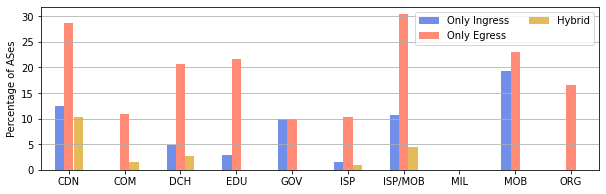

In [19]:
from itertools import cycle, islice

my_colors = list(islice(cycle(['royalblue', 'tomato', 'goldenrod', 'forestgreen']), None, len(table.columns)))
#my_colors = list(islice(cycle(['blue', 'red', 'orange', 'green']), None, len(table.columns)))

ax = table.plot(kind='bar',alpha=0.75, rot=0, figsize=(10,3),color=my_colors)
ax.set(ylabel="Percentage of ASes", xlabel="")
#ax.grid(True)
#ax.set_axisbelow(True)
ax.yaxis.grid()
plt.legend(title="", ncol=2)
fname=IMG+'percent_business.pdf'
plt.savefig(fname, bbox_inches='tight')
plt.show()

## ASes Asymmetry by Business Type  {fig:business_asy_ans.pdf}

In [20]:
df=class_view()
#df.groupby(['usage_type','type']).agg(count_col=pd.NamedAgg(column='asn', aggfunc="count"))
df = df[ df['type'].isin(['hybrid','asy_in','asy_out','sym']) ]
df

,ixp,asn,as_name,method,type,total_nets,total_nets_without_discards,usage_type
0,six,101,Pacific Northwest Gigapop,any23,asy_out,7.0,7.0,EDU
1,six,101,Pacific Northwest Gigapop,any24,asy_out,7.0,7.0,EDU
2,six,101,Pacific Northwest Gigapop,asy23,asy_out,7.0,7.0,EDU
3,six,101,Pacific Northwest Gigapop,asy24,asy_out,7.0,7.0,EDU
4,six,10242,US Internet,any23,sym,256.0,256.0,ISP
...,...,...,...,...,...,...,...,...
13551,linx,9583,Sify Technologies Ltd,asy24,sym,1277.0,1277.0,ISP
13552,amsix,9605,NTT DoCoMo Inc.,any23,sym,1038.0,1038.0,CDN
13553,amsix,9605,NTT DoCoMo Inc.,any24,sym,1041.0,1041.0,CDN
13554,amsix,9605,NTT DoCoMo Inc.,asy23,sym,1038.0,1038.0,CDN


In [21]:
df[['asn','method','type']].duplicated().count()

12110

type,Only Ingress,Only Egress,Hybrid,sym
usage_type,,,,
CDN,54.0,123.0,44.0,209.0
COM,NaN,152.0,20.0,1228.0
DCH,97.0,406.0,52.0,1417.0
EDU,4.0,30.0,NaN,104.0
GOV,4.0,4.0,NaN,32.0
...,...,...,...,...
ISP/MOB,12.0,34.0,5.0,61.0
MIL,NaN,NaN,NaN,4.0
MOB,10.0,12.0,NaN,30.0


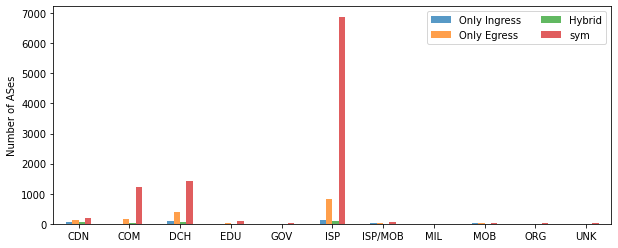

In [22]:
col={'usage_type':'Usage Type', 'hybrid':'Hybrid','asy_in':'Only Ingress','asy_out':'Only Egress'}
table = df[['usage_type','type','asn']]
table = table.pivot_table(index='usage_type', columns="type", aggfunc='count')
table.columns=table.columns.droplevel()

#table = table.reset_index()
table = table.rename(columns=col)
#table = table.set_index('Usage Type')
#table = table.reset_index()
#table.drop(columns='type')
display(table)
ax = table.plot(kind='bar',alpha=0.75, rot=0, figsize=(10,4))
ax.set(ylabel="Number of ASes", xlabel="")
plt.legend(title="", ncol=2)
fname=IMG+'business_asy24_ans_sym.pdf'
plt.savefig(fname, bbox_inches='tight')
plt.show()

type,Only Ingress,Only Egress,Hybrid
usage_type,,,
CDN,54.0,123.0,44.0
COM,NaN,152.0,20.0
DCH,97.0,406.0,52.0
EDU,4.0,30.0,NaN
GOV,4.0,4.0,NaN
ISP,124.0,812.0,80.0
ISP/MOB,12.0,34.0,5.0
MOB,10.0,12.0,NaN
ORG,NaN,4.0,NaN


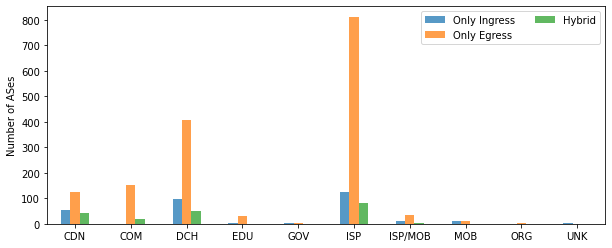

In [23]:
df = df[ df['type'].isin(['hybrid','asy_in','asy_out']) ]

col={'usage_type':'Usage Type', 'hybrid':'Hybrid','asy_in':'Only Ingress','asy_out':'Only Egress'}
table = df[['usage_type','type','asn']]
table = table.pivot_table(index='usage_type', columns="type", aggfunc='count')
table.columns=table.columns.droplevel()

#table = table.reset_index()
table = table.rename(columns=col)
#table = table.set_index('Usage Type')
#table = table.reset_index()
#table.drop(columns='type')
display(table)
ax = table.plot(kind='bar',alpha=0.75, rot=0, figsize=(10,4))
ax.set(ylabel="Number of ASes", xlabel="")
plt.legend(title="", ncol=2)
fname=IMG+'business_asy24_ans.pdf'
plt.savefig(fname, bbox_inches='tight')
plt.show()

## Full Asymmetry view (02-05-2022)

In [25]:
df=result_view('full','asn','24')

Reading results/result_table_ases_up_and_open.csv


In [26]:
df

,ixp,date,nei_asn24,qt_asn_sym24,qt_asn_asy24_in,qt_asn_asy24_out,qt_asn_hib24
97,amsix,2022-05-02,57460.0,17749.0,7316.0,8735.0,529.0
105,linx,2022-05-02,57421.0,14070.0,8736.0,8987.0,513.0
113,poaixbr,2022-05-02,57490.0,2806.0,1081.0,2144.0,53.0


In [27]:
df=result_view('full','net','24')
df

,ixp,date,nei_net24,qt_net_sym24,qt_net_asy24_in,qt_net_asy24_out
97,amsix,2022-05-02,795584.0,439085.0,178033.0,178466.0
105,linx,2022-05-02,958614.0,290111.0,330086.0,338417.0
113,poaixbr,2022-05-02,50945.0,19377.0,19245.0,12323.0
